In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/storage/ducpm/lung-segmentation


In [2]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
import pytorch_lightning as pl
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import transforms

from src.data import PlethoraDataModule, Covid19DataModule, Covid19Dataset
from src.data.preprocess import *
from src.models.unet import UNet
from src.visualization import plot_batch, plot_true_vs_pred
from src.metrics import dice_coeff_vectorized

In [4]:
data_module_args = {                                                                                                                                              
   "batch_size": 16,
   "img_size": 512,
   "clip_low": -1000,
   "clip_high": 1000,
   "pin_memory": True,
   "num_workers": 4
}                                                                                                                                                                 
dm = Covid19DataModule(**data_module_args)        
dm.setup()
print("No. test samples:", len(dm.test_ds))
test_loader = dm.test_dataloader()

No. test samples: 3520


In [17]:
# test on visually different images
ds = Covid19Dataset(ct_dir="data/raw/COVID-19-CT-Seg_20cases/ct_scans/",
                    mask_dir="data/raw/COVID-19-CT-Seg_20cases/lung_masks/",
                    ct_ids=["radiopaedia_7_85703_0"],
                    transform=dm.transform)
test_loader = DataLoader(ds, batch_size=16, pin_memory=True, shuffle=False)
len(ds)

45

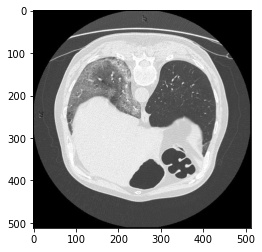

In [22]:
sample = ds[36]
img, mask = sample['img'], sample['mask']
plt.imshow(img.squeeze(), cmap='gray')

In [23]:
device = "cuda:0"
from src.models.unet import UNet
net = UNet.load_from_checkpoint("logs/unet-plethora-512/version_0/ckpts/epoch=8-dice_coeff_val=0.942.ckpt")
net.to(device).eval();

In [30]:
# sanity check model predictions
it = iter(test_loader)
for _ in range(1):
    batch = next(it)
# batch['img'] = batch['img'][:4]
# batch['mask'] = batch['mask'][:4]
with torch.no_grad():
    logits = net(batch['img'].to(device))
    pred_masks = torch.argmax(logits, dim=1)

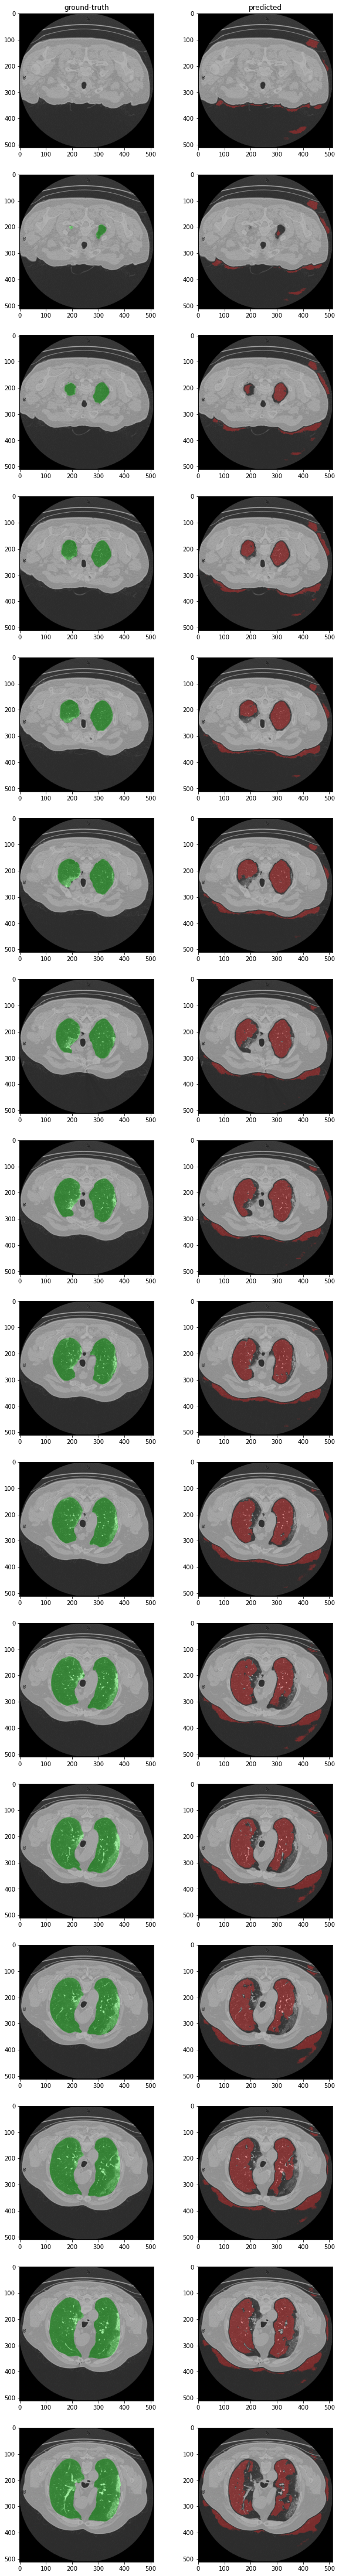

In [33]:
plot_true_vs_pred(batch['img'], 
                  batch['mask'], 
                  pred_masks.cpu(), mask_alpha=0.3)

In [34]:
dice_scores = []
pbar = tqdm(dm.test_dataloader())
# pbar = tqdm(test_loader)
# evaluate on test set
for batch in pbar:
    X, y = batch["img"].to(device), batch["mask"].to(device)
    with torch.no_grad():
        logits = net(X.to(device))
        pred_masks = torch.argmax(logits, dim=1)
        batch_dsc = dice_coeff_vectorized(pred_masks, y, reduce_fn=None)
        dice_scores.append(batch_dsc)
        pbar.set_description(f"dsc={batch_dsc.mean().item():.3f}")
dice_scores = torch.cat(dice_scores)

dsc=0.394: 100%|██████████| 220/220 [10:00<00:00,  2.73s/it]


In [35]:
print("dsc mean:", dice_scores.mean().item())

worst_idxs = torch.argsort(dice_scores, descending=False).cpu()
worst_idxs = worst_idxs[:500].numpy()
worst_idxs = np.random.choice(worst_idxs, size=10, replace=False)
dice_scores[worst_idxs]

dsc mean: 0.7708123922348022


tensor([4.1473e-09, 6.3037e-02, 1.9722e-01, 3.5961e-09, 1.4286e-05, 2.4284e-01,
        1.6170e-01, 4.9998e-05, 3.8962e-09, 3.5088e-07], device='cuda:0')